In [1]:
#default_exp pytorch_graphs

In [2]:
#export


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree
from torch_geometric.data import Data

import tqdm
import livelossplot

In [3]:
plt.style.use("dark_background")

In [4]:
%cd ..

/home/kuba/Projects/github_search


## 1. make pyg graph from repositories

In [5]:
dependency_records_df = pd.read_csv('data/dependency_records.csv').dropna()#.iloc[:1000000]

In [6]:
non_root_dependency_records_df = dependency_records_df[dependency_records_df['source'] != "<ROOT>"]

In [7]:
#export

class PygGraphWrapper:
    """
    holds pytorch_geometric dataset and utils for mapping vertices to names
    """
    def __init__(
            self,
            featurizer,
            records_df,
            source_col='source',
            destination_col='destination'
        ):
        
        vertices = pd.concat([
            records_df[source_col],
            records_df[destination_col]
        ]).drop_duplicates().reset_index(drop=True)
        
        self.vertex_mapping = pd.Series(data=vertices.index, index=vertices.values)
        self.inverse_vertex_mapping = vertices
        edge_index_source = self.vertex_mapping.loc[records_df[source_col]].values
        edge_index_destination = self.vertex_mapping.loc[non_root_dependency_records_df[destination_col]].values
        edge_index = torch.tensor(np.row_stack([edge_index_source, edge_index_destination]))
        features = featurizer(self.vertex_mapping.index)
        self.dataset = Data(
            torch.tensor(features),
            torch.tensor(edge_index)
        )
        

## FastText token features

In [8]:
#export

import fasttext
from mlutil.feature_extraction import embeddings

In [9]:
%%time
fasttext_model = fasttext.load_model("output/python_fasttext.bin")

CPU times: user 8.44 s, sys: 1.97 s, total: 10.4 s
Wall time: 10.4 s


In [10]:
fasttext_embedder = embeddings.FastTextVectorizer(fasttext_model)

In [11]:
%%time
dependency_graph_wrapper = PygGraphWrapper(fasttext_embedder.transform, non_root_dependency_records_df)

CPU times: user 18.9 s, sys: 1.37 s, total: 20.2 s
Wall time: 18.5 s


<ipython-input-7-4eb3e027b388>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(edge_index)


In [21]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size

from torch import Tensor
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn import SAGEConv


class ResidualSAGEConv(SAGEConv):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, **kwargs):
        super(ResidualSAGEConv, self).__init__(**kwargs)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)
            
        out += x_r

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out

In [26]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.loader import NeighborSampler as RawNeighborSampler




class SAGENeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        n_edges = self.adj_t.size(1)
        neg_batch = torch.randint(0, n_edges, (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(SAGENeighborSampler, self).sample(batch)



class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, sage_layer_cls=ResidualSAGEConv):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(sage_layer_cls(in_channels=in_channels, out_channels=hidden_channels))

    def forward(self, x, adjs):
        """
        x - embeddings of nodes
        adjs - 
            list of ((edge_index, edge_data, size))
            data for edges (edge_index contains data in COO format)
            2 lists
            - one for neighboring vertices (positive samples)
            - one for random vertices (negative samples) 
        """
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


data = dependency_graph_wrapper.dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=100, num_layers=2)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
x, edge_index = data.x.to(device), data.edge_index.to(device)

train_loader = SAGENeighborSampler(data.edge_index, sizes=[10, 10], batch_size=2048,
                               shuffle=True, num_nodes=data.num_nodes)


In [27]:
def unsupervised_graphsage_loss(model, xs, adjs):
    out = model(xs, adjs)
    out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

    pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
    neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
    loss = -pos_loss - neg_loss
    return loss, out.size(0)


def train(model, train_loader, optimizer):
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()
        
        loss, size = unsupervised_graphsage_loss(model, x[n_id], adjs)
        
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * size

    return total_loss / data.num_nodes


@torch.no_grad()
def get_val_loss(model, val_loader):
    model.eval()
    for batch_size, n_id, adjs in val_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        
        loss = unsupervised_graphsage_loss(model, x[n_id], adjs)
        total_loss += float(loss) * out.size(0)

    return total_loss 


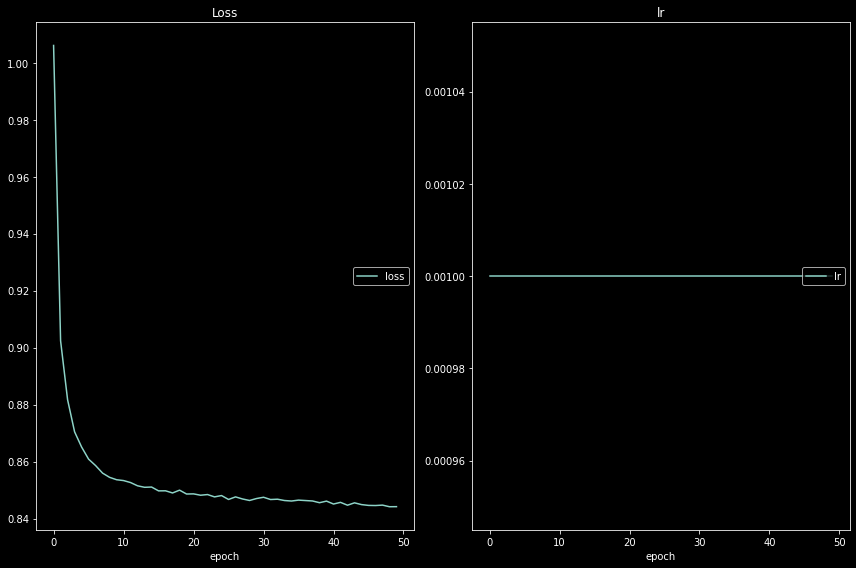

Epoch: 50, Loss: 0.8442, : 100%|██████████| 50/50 [23:24<00:00, 28.09s/it]

Loss
	loss             	 (min:    0.844, max:    1.006, cur:    0.844)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)


In [28]:
rnge = tqdm.tqdm(range(1, 51))

plotlosses = livelossplot.PlotLosses()

for epoch in rnge:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1, threshold=2e-3)
    loss = train(model, train_loader, optimizer)
    scheduler.step(loss)
    plotlosses.update({"loss": loss, "lr": optimizer.state_dict()['param_groups'][0]['lr']})
    plotlosses.send()
    rnge.set_description(f'Epoch: {epoch}, Loss: {loss:.4f}, ')

In [30]:
graphsage_features = model.full_forward(x, edge_index).cpu().detach().numpy()

In [31]:
graphsage_features.shape

(1382270, 100)

In [32]:
from gensim.models import KeyedVectors
graphsage_kv = KeyedVectors(graphsage_features.shape[1])
graphsage_kv.add(dependency_graph_wrapper.inverse_vertex_mapping.values, graphsage_features)

In [33]:
graphsage_kv.save("output/residual_graphsage_embeddings.bin")

In [34]:
dependency_graph_wrapper.vertex_mapping.shape

(1382270,)

In [35]:
example_repo = 'huggingface/transformers'
dependency_graph_wrapper.vertex_mapping[example_repo]

9981

In [36]:
dependency_graph_wrapper.inverse_vertex_mapping

0          0492wzl/tensorflow_slim_densenet
1                             08173021/FCOS
2                        09jvilla/CS234_gym
3                0h-n0/cdn_molecule_pytorch
4                            0h-n0/tfdbonas
                         ...               
1382265                     loss_accountant
1382266                    delta_accountant
1382267                 accuracy_accountant
1382268                         participate
1382269                         coincidence
Length: 1382270, dtype: object

In [37]:
dependency_graph_wrapper.inverse_vertex_mapping[dependency_graph_wrapper.inverse_vertex_mapping.str.contains("bert")][:50]

182      AbertayMachineLearningGroup/zero-day-detection
201                           AdalbertoCq/Pathology-GAN
263                           AlbertoParravicini/grcuda
371           AndriyMulyar/bert_document_classification
460              ArthurRizar/dialog_state_tracking_bert
1153                     DeligientSloth/bert-tensorflow
1360                       EthanWYB/bert-classification
1946                                   IIEKES/cbert_aug
2070                                     JNUpython/bert
2542                               LeoWood/bert-horovod
3171                      Nstats/bert_senti_analysis_ch
3323                  PaulAlbert31/LabelNoiseCorrection
3324                                 PaulAlbert31/ReLaB
3596                               RenXiangyuan/tf_bert
3633                             RobertHong1992/Resnest
3634             RobertJaro/SolarImageQualityAssessment
3765                    SYangDong/bert-with-frozen-code
4027                            Soikonomou/alber

In [38]:
from sklearn import metrics

In [39]:
def get_most_similar_repos(example_repo, n_repos):
    similarities = metrics.pairwise.cosine_distances([graphsage_features[dependency_graph_wrapper.vertex_mapping[example_repo]]], graphsage_features)[0]
    repo_inverse_vertex_mapping = dependency_graph_wrapper.inverse_vertex_mapping
    repo_inverse_vertex_mapping = repo_inverse_vertex_mapping[repo_inverse_vertex_mapping.str.contains("/")]
    return dependency_graph_wrapper.inverse_vertex_mapping[(similarities[:len(repo_inverse_vertex_mapping)]).argsort()[:n_repos]]

In [40]:
get_most_similar_repos(example_repo, 20)

9981               huggingface/transformers
291                        AlexeyAB/darknet
18884                       zp1018/ReID-MGN
11097                    jych/nips2015_vrnn
10991            jsyzeng/rock_class_xgboost
546               BOBrown/deeparsing-master
10695                 jianing-sun/Mask-YOLO
6054            asapegin/pyspark-kmetamodes
6469                   bhacquin/UDA_pytorch
17645              wacr2008/tensorflow_crnn
2062                          JHL-HUST/FGPM
6693                    brooklyn1900/SPCNet
5868                 anuja-meetoo/SmartEXP3
11621                 laiviet/ConvAMR-torch
733                   CJBartel/compmatscipy
8122                         donnyslin/KCAT
9097     fyangneil/pavement-crack-detection
11029                         jun-fang/PWLQ
6985                         changlin31/DNA
7464                      ctuning/ck-mlperf
dtype: object

In [41]:
get_most_similar_repos(example_repo, 20)

9981               huggingface/transformers
291                        AlexeyAB/darknet
18884                       zp1018/ReID-MGN
11097                    jych/nips2015_vrnn
10991            jsyzeng/rock_class_xgboost
546               BOBrown/deeparsing-master
10695                 jianing-sun/Mask-YOLO
6054            asapegin/pyspark-kmetamodes
6469                   bhacquin/UDA_pytorch
17645              wacr2008/tensorflow_crnn
2062                          JHL-HUST/FGPM
6693                    brooklyn1900/SPCNet
5868                 anuja-meetoo/SmartEXP3
11621                 laiviet/ConvAMR-torch
733                   CJBartel/compmatscipy
8122                         donnyslin/KCAT
9097     fyangneil/pavement-crack-detection
11029                         jun-fang/PWLQ
6985                         changlin31/DNA
7464                      ctuning/ck-mlperf
dtype: object

In [42]:
get_most_similar_repos("open-mmlab/mmsegmentation", 20)

13903                            open-mmlab/mmsegmentation
7553                            d-li14/mobilenetv3.pytorch
4777                                       YH0517/CLCI_Net
2371                    KevinJia1212/yolact_cityscapes_550
17387                                vanzytay/KDD2018_MPCN
10683                                         jiamings/ais
18597                                       yyyaoyuan/CWAN
8337                                 eg4000/SKU110K_CVPR19
15886                    sidneykingsley/pix2pix-tensorflow
9003                                fpv-iplab/DA-RetinaNet
10905                           jongwankim0317/torchdiffeq
6027                                  artxtech/darknet-rnn
16472                           sylqiu/tof_rgbd_processing
1176                                  DialRC/LetsGoDataset
8298                                           ec1340/GSAE
17989                                          xar47x/pose
13325                                       nanguoshun/L

In [43]:
get_most_similar_repos("pytorch/pytorch", 20)

14558                           pytorch/pytorch
7685                    datquocnguyen/BioPosDep
12676                memray/OpenNMT-kpg-release
5089                           aarthipriyar/GAN
3635      RobinBruegger/PartiallyReversibleUnet
6755                               bzhangGo/ATR
15679           sgiguere/RobinHood-NeurIPS-2019
15692                    shahrukhqasim/TIES-2.0
812                             CannyLab/ExpExp
3860      SeventeenChen/fashionMNIST_CNN_master
10138                  icmlanon58443043/vizdoom
12346                           manacho14/CLASH
473                        AskingQ/If-or-If-not
4664                             Wenhui-Yu/TDAR
15161                  rronan/IntPhys-Baselines
8062                     dmitryduev/DeepStreaks
12999                         mloning/sktime-m4
4973     Zgrigorian/libparanumal-InsTemperature
4009          Smart-Harvesting/sh2-dblp-ranking
15026                      rmalav15/Super-SloMo
dtype: object